Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

Soruce: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm


import os
import pickle
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open("all_converted_data.pkl", 'rb') as picklefile: 
    df_new = pickle.load(picklefile)
df_new.shape


(1370538, 13)

In [3]:
selectedFeatures=['ip', 'app', 'device', 'os', 'channel','hour']

In [17]:
df_new.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,date,day,month,year
0,117867,12,1,18,19,2017-11-08 23:43:20,NaN,0,23,2017-11-08,8,11,2017
1,43715,17,1,13,280,2017-11-08 05:36:19,NaN,0,5,2017-11-08,8,11,2017
2,183537,2,1,13,477,2017-11-06 17:21:36,NaN,0,17,2017-11-06,6,11,2017
3,46323,3,1,13,402,2017-11-09 06:26:40,NaN,0,6,2017-11-09,9,11,2017
4,4248,9,1,13,489,2017-11-07 10:28:31,NaN,0,10,2017-11-07,7,11,2017


In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370538 entries, 0 to 1370537
Data columns (total 13 columns):
ip                 1370538 non-null int64
app                1370538 non-null int64
device             1370538 non-null int64
os                 1370538 non-null int64
channel            1370538 non-null int64
click_time         1370538 non-null datetime64[ns]
attributed_time    456846 non-null object
is_attributed      1370538 non-null int64
hour               1370538 non-null int64
date               1370538 non-null object
day                1370538 non-null int64
month              1370538 non-null int64
year               1370538 non-null int64
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 135.9+ MB


In [7]:
df_new.dtypes

ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
hour                        int64
date                       object
day                         int64
month                       int64
year                        int64
dtype: object

In [8]:
df_new.describe()

,ip,app,device,os,channel,is_attributed,hour,day,month,year
count,1.370538e+06,1.370538e+06,1.370538e+06,1.370538e+06,1.370538e+06,1.370538e+06,1.370538e+06,1.370538e+06,1370538.0,1370538.0
mean,1.158021e+05,1.791086e+01,2.501031e+01,2.327018e+01,2.477990e+02,3.333333e-01,9.063776e+00,7.869820e+00,11.0,2017.0
std,9.031810e+04,2.411322e+01,2.461967e+02,5.529785e+01,1.281404e+02,4.714047e-01,6.084402e+00,8.850820e-01,0.0,0.0
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,11.0,2017.0
25%,4.636425e+04,5.000000e+00,1.000000e+00,1.300000e+01,1.340000e+02,0.000000e+00,4.000000e+00,7.000000e+00,11.0,2017.0
50%,9.411700e+04,1.300000e+01,1.000000e+00,1.900000e+01,2.320000e+02,0.000000e+00,9.000000e+00,8.000000e+00,11.0,2017.0
75%,1.655038e+05,1.900000e+01,1.000000e+00,2.200000e+01,3.430000e+02,1.000000e+00,1.300000e+01,9.000000e+00,11.0,2017.0
max,3.647780e+05,7.680000e+02,4.223000e+03,8.660000e+02,4.980000e+02,1.000000e+00,2.300000e+01,9.000000e+00,11.0,2017.0


In [12]:
df_new['year'].value_counts()

2017    1370538
Name: year, dtype: int64

In [11]:
df_new['month'].value_counts()

11    1370538
Name: month, dtype: int64

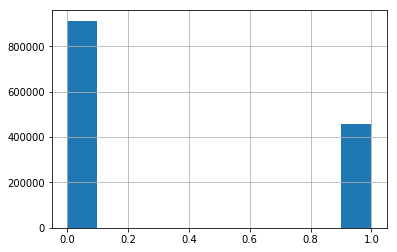

In [13]:
df_new['is_attributed'].hist()

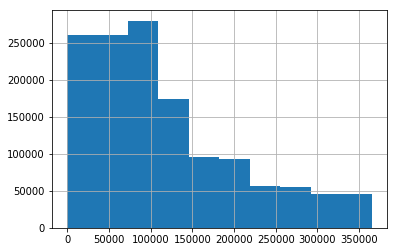

In [14]:
df_new['ip'].hist()

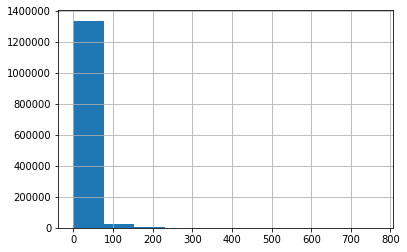

In [15]:
df_new['app'].hist()

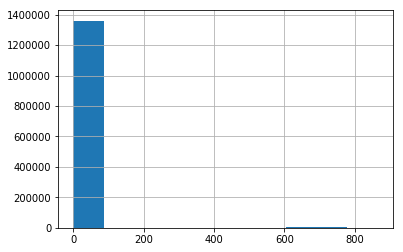

In [18]:
df_new['os'].hist()